In [1]:
from media_processing.data_processor import DataProcessor, DataLoader

from model import *
import torch.optim as optim
import torch.nn as nn
import torch

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
def metrics_item(output, target):
    pred = (output > 0.5).float()
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_item(loss_func, output, target, optimizer=None):
    loss_value = loss_func(output, target)

    metrics = metrics_item(output, target)

    if optimizer is not None:
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
    
    return loss_value.item(), metrics

def loss_epoch(model, loss_func, data_loader, device, optimizer=None):

    running_loss = 0.0
    running_metric = 0.0
    
    for markers, video, audio, _ in tqdm(data_loader.train(), desc='Training Videos', unit='video'):
        video, audio, markers = video.to(device), audio.to(device), markers.to(device)
        model_output = model(video, audio)

        loss_value, metrics_value = loss_item(
            loss_func, model_output, markers, optimizer
        )

        running_loss += loss_value
        running_metric += metrics_value
            
    average_loss = running_loss / len(data_loader.train_videos)
    average_metric = running_metric / len(data_loader.train_videos)

    return average_loss, average_metric

In [3]:
def save_model(model):
    model_dir = os.path.join(os.getcwd(), 'data', 'models')
    os.makedirs(model_dir, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(model_dir, 'model_.pth'))

def load_model(name):
    model_dir = os.path.join(os.getcwd(), 'data', 'models')
    model = Net_v2_Improved()
    model.load_state_dict(torch.load(os.path.join(model_dir, f'{name}.pth'), weights_only=True))
    return model

In [4]:
def train(model, params, device):

    epochs = params["epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    dl = params["train_val_dl"]
    lr_scheduler = params["lr_scheduler"]

    loss_train_history = []
    metric_train_history = []
    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, dl, device, opt)

        loss_train_history.append(train_loss)
        metric_train_history.append(train_metric)

        if train_loss < best_loss:
            best_loss = train_loss
            save_model(model)
        
        lr_scheduler.step()
        if epoch % 2 == 0:
            print(f"Epoch {epoch + 1}/{epochs}: train loss: {train_loss:.6f}, train accuracy: {train_metric:.2f}")

    model = load_model('model_')
    return model, loss_train_history, metric_train_history

In [5]:
def val(model, params):
    dl = params["train_val_dl"]
    loss_func = params["loss_func"]
    loss_val_history = []
    metric_val_history = []
    output_labels = []

    running_loss = 0.0
    for marker, video, audio, _ in dl.test():
        model.eval()
        model_output = model(video, audio)

        running_loss, running_metric = loss_item(loss_func, model_output, marker)
        output_labels.append([model_output, marker])
        loss_val_history.append(running_loss)
        metric_val_history.append(running_metric)

    return loss_val_history, metric_val_history, output_labels

In [6]:
skip = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 3e-4
model = Net_v2_Improved().to(device)
dataloader = DataLoader(shuffle=True)
dataloader.train_test_datasets()

loss_func = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

params = {
    "epochs": 20,
    "optimizer": optimizer,
    "loss_func": loss_func,
    "train_val_dl": dataloader,
    "lr_scheduler": lr_scheduler,
}

In [7]:
if not skip:
    model_trained, loss_train_history, metric_train_history = train(model, params, device)

Training Videos: 11video [00:23,  2.13s/video]


Epoch 1/20: train loss: 0.694044, train accuracy: 198.00


Training Videos: 11video [00:23,  2.14s/video]
Training Videos: 11video [00:23,  2.12s/video]


Epoch 3/20: train loss: 0.520110, train accuracy: 245.55


Training Videos: 11video [00:22,  2.09s/video]
Training Videos: 11video [00:22,  2.09s/video]


Epoch 5/20: train loss: 0.176645, train accuracy: 308.73


Training Videos: 11video [00:23,  2.09s/video]
Training Videos: 11video [00:22,  2.09s/video]


Epoch 7/20: train loss: 0.142759, train accuracy: 313.27


Training Videos: 11video [00:23,  2.10s/video]
Training Videos: 11video [00:23,  2.10s/video]


Epoch 9/20: train loss: 0.077646, train accuracy: 322.82


Training Videos: 11video [00:22,  2.08s/video]
Training Videos: 11video [00:23,  2.10s/video]


Epoch 11/20: train loss: 0.048113, train accuracy: 326.27


Training Videos: 11video [00:22,  2.09s/video]
Training Videos: 11video [00:22,  2.09s/video]


Epoch 13/20: train loss: 0.020519, train accuracy: 329.55


Training Videos: 11video [00:23,  2.10s/video]
Training Videos: 11video [00:22,  2.09s/video]


Epoch 15/20: train loss: 0.012009, train accuracy: 330.09


Training Videos: 11video [00:23,  2.10s/video]
Training Videos: 11video [00:23,  2.15s/video]


Epoch 17/20: train loss: 0.010341, train accuracy: 330.09


Training Videos: 11video [00:23,  2.11s/video]
Training Videos: 11video [00:23,  2.15s/video]


Epoch 19/20: train loss: 0.011031, train accuracy: 330.00


Training Videos: 11video [00:23,  2.15s/video]


In [11]:
# model_net_v2 = load_model('net_v2_improved')

with torch.no_grad():
    loss_val_history, metric_val_history, output_labels = val(model_trained, params)
print(f"Validation loss: {np.mean(loss_val_history):.6f}, validation accuracy: {np.mean(metric_val_history):.2f}")

Validation loss: 2.042752, validation accuracy: 193.00


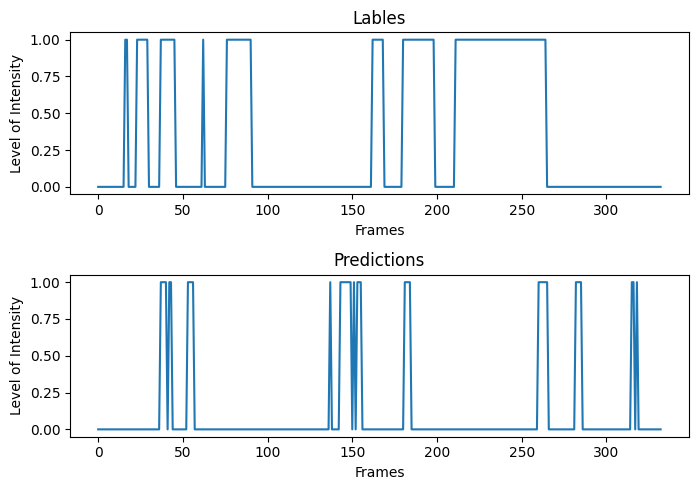

In [15]:
def plots(pred, markers):
    fig, ax = plt.subplots(2, 1, figsize=(7,5))
    ax[0].plot(range(markers.shape[0]), markers.reshape(-1))
    ax[0].set_title('Lables')
    ax[0].set_xlabel('Frames')
    ax[0].set_ylabel('Level of Intensity')
    ax[1].plot(range(pred.shape[0]), (pred > 0.5).float().reshape(-1))
    ax[1].set_title('Predictions')
    ax[1].set_xlabel('Frames')
    ax[1].set_ylabel('Level of Intensity')
    plt.tight_layout()
    plt.show()

num_video = 0
plots(output_labels[num_video][0], output_labels[num_video][1])

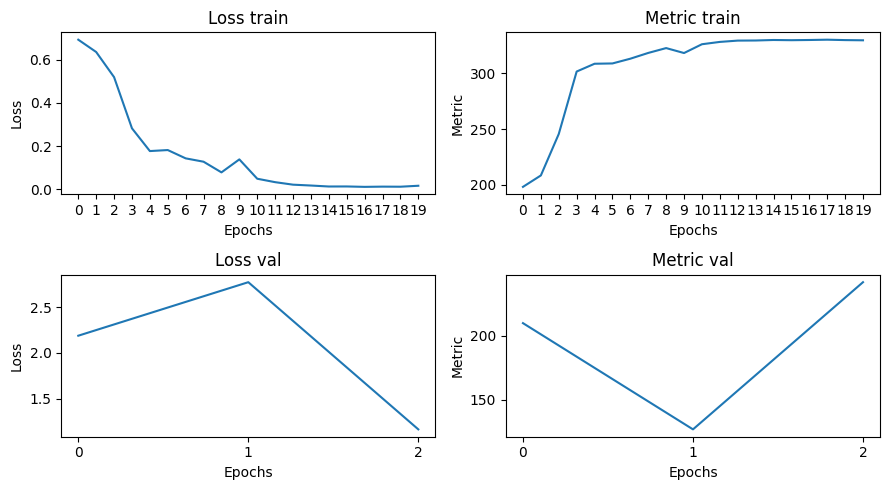

In [16]:
def get_loss_metrics_plots(losses_metrics):
    nrow = 2
    ncol = 2
    fig, ax = plt.subplots(nrow, ncol, figsize=(9,5))
    titles = ['Loss', 'Metric']
    categories = ['train', 'val']
    for row in range(nrow):
        for col in range(ncol):
            index = row * 2 + col
            val = losses_metrics[index]
            ax[row][col].plot(range(len(val)), val)
            ax[row][col].set_title(f'{titles[col]} {categories[row]}')
            ax[row][col].set_xlabel('Epochs')
            ax[row][col].set_ylabel(titles[col])
            ax[row][col].set_xticks(range(len(val)))
    plt.tight_layout()
    plt.show()

losses_metrics = [loss_train_history, metric_train_history, loss_val_history, metric_val_history]
get_loss_metrics_plots(losses_metrics)